In [1]:
# Import the init_paths module
from init_paths import (
    PROJECT_ROOT,
    DATASETS_DIR,
    ANALYSIS_DIR,
    EXPERIMENTS_DIR,
    IMAGES_DIR,
    GEN_DATA_DIR,
    LOGS_DIR,
    get_project_path
)

Paths initialized successfully. You can now use PROJECT_ROOT, DATASETS_DIR, etc.


In [2]:
import pandas as pd
import sys
from pathlib import Path
import os
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import os
import pandas as pd 
import re

In [3]:
# from analysis.unsupervised import *
from analysis.supervised import *
from analysis.models import * 

In [4]:
publication = ["public_1", "public_2"][1]

folder_path = DATASETS_DIR/ f"prompt_activations/{publication}/"
files = os.listdir(folder_path)

models_list = list(models.keys())
model = models_list[0]

for file in files:
    
    if "rated" in file and ".pt" in file and model in file: 
      print(file)
      path = folder_path / file
    if "rated" in file and ".csv" in file and model in file: 
      print(file)
      csv = folder_path / file


gemma-7b-it_rated.pkl_tensors.pt
gemma-7b-it_rated.pkl_rest.csv


In [5]:
model_name, num_layers, rating_column, hf_ident, input_size = get_model_details(path)

print(num_layers)
print(input_size)

28
3072


# Load data

In [6]:
# import torch
tensors_loaded = torch.load(path)

NEED_TO_FLIP = True # cursor told me I didn't have to flip, but if I don't, the probe results suck
sequence_length = int(tensors_loaded['data'].shape[0]/num_layers)
if NEED_TO_FLIP:
    activations_start = tensors_loaded['data'].reshape(num_layers, sequence_length, input_size)
    activations = torch.transpose(activations_start, 0, 1)
    labels_start = tensors_loaded['labels'].reshape(num_layers, sequence_length)
    labels = torch.transpose(labels_start, 0, 1)
else:
    activations = tensors_loaded['data'].reshape(sequence_length, num_layers, input_size)
    labels = tensors_loaded['labels'].reshape(sequence_length, num_layers)

all_rows_internally_same = torch.all(torch.all(labels == labels[:,[0]], dim=1)).item()
assert all_rows_internally_same, "Labels are not internally consistent"
labels = labels[:, 0]

ADD_MEAN_LAYER = True
if ADD_MEAN_LAYER:
    # Calculate mean over layers dimension (dim=1, keepdim=True)
    mean_layer = torch.mean(activations, dim=1, keepdim=True)  

    # Concatenate mean layer to original activations
    activations_with_mean = torch.cat([activations, mean_layer], dim=1)  # New shape: (n_samples, n_layers+1, n_vector_length)
    assert (activations_with_mean[:, 5, :] == activations[:, 5, :]).all()
    activations = activations_with_mean


n_layers = activations.shape[1]
n_samples = activations.shape[0]
n_vector_length = activations.shape[2]
activations.shape, labels.shape

/tmp/ipykernel_2947832/1474139197.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors_loaded = torch.load(path)


(torch.Size([7266, 37, 4096]), torch.Size([7266]))

In [7]:
df = pd.read_csv(csv)

In [8]:
def train_test_split_activations(activations, labels):
    assert len(df) == len(activations)
    idx = range(len(df))
    # Randomly shuffle indices
    np.random.seed(42)
    shuffled_idx = np.random.permutation(idx)

    # Split into train/test sets (80/20 split)
    train_idx = shuffled_idx[:int(0.8 * len(idx))]
    test_idx = shuffled_idx[int(0.8 * len(idx)):]

    # Select train/test data using indices
    train_activations = activations[train_idx]
    test_activations = activations[test_idx]
    train_labels = labels[train_idx] 
    test_labels = labels[test_idx]
    return train_activations, train_labels, test_activations, test_labels

train_activations, train_labels, test_activations, test_labels =train_test_split_activations(activations, labels)

def plot_layer_transfer_accuracy_old(test_accuracies_for_plot):

    # Create figure with larger size    
    plt.figure(figsize=(12, 10))

    # Create heatmap
    sns.heatmap(test_accuracies_for_plot, 
                annot=True,  # Show numbers in cells
                fmt='.2f',   # Format numbers to 2 decimal places
                cmap='viridis',  # Color scheme
                xticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on x-axis
                yticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on y-axis
                cbar_kws={'label': 'Accuracy'})  # Colorbar label

    # Add labels and title
    plt.xlabel('Test Layer')
    plt.ylabel('Train Layer')
    plt.title(f'Cross-Layer Generalization Matrix')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save the plot if needed
    # save_path = project_root / f"datasets/layer_transfer/cross_layer_generalization.pdf"
    # save_path.parent.mkdir(parents=True, exist_ok=True)
    save_path = f"datasets/{publication}/layer_transfer/cross_layer_generalization.pdf"

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()




# Plot

In [9]:
def plot_layer_transfer_accuracy(test_accuracies_for_plot, model_name, specifier="logistic_regression"):
    # Plot main heatmap
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.labelpad': 10
    })
    plt.rcParams.update({
        'axes.spines.top': False,
        'axes.spines.right': False,
        # Remove font family settings since Arial is not available
        'axes.labelpad': 10
    })
    
    # Create main heatmap
    plt.figure(figsize=(10, 8), dpi=300)
    heatmap = sns.heatmap(100*test_accuracies_for_plot,
                         annot=False,
                         # cmap='viridis',
                         xticklabels=[str(i) for i in list(range(n_layers-1))+["mean"]],
                         yticklabels=[str(i) for i in list(range(n_layers-1))+["mean"]],
                         square=True,
                         vmin=50,
                         vmax=100,
                         cbar=False, 
                         )  # Remove colorbar from main plot
    
    # Add labels to main heatmap
    plt.xlabel('Target Layer', fontsize=16, fontweight='bold')
    plt.ylabel('Source Layer', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    # Adjust layout and save main heatmap
    plt.tight_layout()
    save_path = f"/data/nathalie_maria_kirch/ERA_Fellowship/{publication}/images/{publication}/layer_transfer/{model_name}_cross_layer_generalization_{specifier}"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.savefig(f"{save_path}.pdf", bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f"{save_path}.png", bbox_inches='tight', dpi=300, format='png')
    plt.show()
    
    plt.style.use('seaborn-v0_8-paper')

    # Create separate figure for colorbar
    fig_colorbar = plt.figure(figsize=(8, 1), dpi=300)
    ax_colorbar = fig_colorbar.add_axes([0.05, 0.5, 0.9, 0.15])
    
    # Create colorbar with viridis colormap
    norm = plt.Normalize(vmin=50, vmax=100)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='rocket'),
                       cax=ax_colorbar,
                       orientation='horizontal',
                       ticks=[50, 60, 70, 80, 90, 100])
    
    # Style the colorbar
    ax_colorbar.set_xlabel('Classification Accuracy (%)', fontsize=16, fontweight='bold')
    cbar.ax.tick_params(labelsize=14)
    

    # Save colorbar separately
    plt.savefig(f"{save_path}_colorbar.pdf", bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f"{save_path}_colorbar.png", bbox_inches='tight', dpi=300, format='png')
    plt.show()

In [10]:
def plot_layer_transfer_accuracy(test_accuracies_for_plot, model_name, specifier="logistic_regression"):
    # Plot main heatmap
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.labelpad': 10,
        'font.size': 14,  # Increase base font size
    })

    # Create main heatmap
    plt.figure(figsize=(10, 8), dpi=300)
    
    # Create tick labels with every 5th layer
    all_layers = list(range(n_layers-1)) + ["mean"]
    xticklabels = []
    yticklabels = []
    
    for i in all_layers:
        if isinstance(i, str):  # Handle "mean" case
            xticklabels.append(i)
            yticklabels.append(i)
        elif i % 5 == 0:  # Handle number case
            xticklabels.append(str(i))
            yticklabels.append(str(i))
        else:
            xticklabels.append("")
            yticklabels.append("")
    
    heatmap = sns.heatmap(100*test_accuracies_for_plot,
                         annot=False,
                         xticklabels=xticklabels,
                         yticklabels=yticklabels,
                         square=True,
                         vmin=50,
                         vmax=100,
                         cbar=False)
    
    # Add labels to main heatmap with larger font sizes
    plt.xlabel('Target Layer', fontsize=18, fontweight='bold')
    plt.ylabel('Source Layer', fontsize=18, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    
    # Adjust layout and save main heatmap
    plt.tight_layout()
    save_path = IMAGES_DIR / f"layer_transfer/{model_name}_cross_layer_generalization_{specifier}"
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(f"{save_path}.pdf", bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f"{save_path}.png", bbox_inches='tight', dpi=300, format='png')
    plt.show()

    plt.style.use('seaborn-v0_8-paper')
    # Create separate figure for colorbar
    fig_colorbar = plt.figure(figsize=(8, 1), dpi=300)
    ax_colorbar = fig_colorbar.add_axes([0.05, 0.5, 0.9, 0.15])
    
    # Create colorbar with rocket colormap
    norm = plt.Normalize(vmin=50, vmax=100)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='rocket'),
                       cax=ax_colorbar,
                       orientation='horizontal',
                       ticks=[50, 60, 70, 80, 90, 100])
    
    # Style the colorbar with larger font sizes
    ax_colorbar.set_xlabel('Classification Accuracy (%)', fontsize=18, fontweight='bold')
    cbar.ax.tick_params(labelsize=16)
    
    # Save colorbar separately
    plt.savefig(f"{save_path}_colorbar.pdf", bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f"{save_path}_colorbar.png", bbox_inches='tight', dpi=300, format='png')
    plt.show()

In [ ]:
fname_save_template = DATASETS_DIR / f"{publication}/{model_name}/layer_transfer_logistic_regression_layer_accuracies.csv"

print(fname_save_template)

os.makedirs(os.path.dirname(fname_save_template), exist_ok=True)

for save_id in range(3):  
    test_accuracies = -1*np.ones((n_layers,n_layers))
    train_accuracies = -1*np.ones(n_layers)
    for layer_train in tqdm.tqdm(range(n_layers)):
        log_model = LogisticRegression(solver='lbfgs', max_iter=1000)
        log_model.fit(train_activations[:,layer_train,:], train_labels)
        for layer_test in range(n_layers):
            test_accuracy = log_model.score(test_activations[:,layer_test,:], test_labels)
            test_accuracies[layer_train,layer_test] = test_accuracy
    np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies, delimiter=",")


l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

plot_layer_transfer_accuracy(test_accuracies_mean, model_name = model_name, specifier = "logistic_regression")
                             


In [ ]:
fname_save_template = DATASETS_DIR / f"{publication}/{model_name}/layer_transfer_mlp_layer_accuracies_layer_accuracies.csv"
os.makedirs(os.path.dirname(fname_save_template), exist_ok=True)
for save_id in range(3):    
    test_accuracies_mlp = -1*np.ones((n_layers,n_layers))
    for layer_train in tqdm.tqdm(range(n_layers)):
        mlp = SimpleMLP(input_size=train_activations.shape[-1])
        mlp.to("cuda")
        mlp.train_MLP(train_data = train_activations[:,layer_train,:], train_labels = train_labels, num_epochs = 500)
        for layer_test in range(n_layers):
            test_accuracy, conf_matrix = mlp.get_accuracy(test_data = test_activations[:,layer_test,:], test_labels = test_labels)
            test_accuracies_mlp[layer_train,layer_test] = test_accuracy
    np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies_mlp, delimiter=",")
    
l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

plot_layer_transfer_accuracy(test_accuracies_mean,  model_name = model_name, specifier = "mlp")

In [ ]:
# transformer probe
fname_save_template = DATASETS_DIR / f"{publication}/{model_name}/layer_transfer_transformer_layer_accuracies_layer_accuracies.csv"
os.makedirs(os.path.dirname(fname_save_template), exist_ok=True)

for save_id in range(3):    
    test_accuracies_transformer = -1*np.ones((n_layers,n_layers))
    for layer_train in tqdm.tqdm(range(n_layers)):
        # Initialize and train transformer probe
        transformer = TransformerProbe(input_size=train_activations.shape[-1])
        transformer.to("cuda")
        transformer.train_probe(
            train_data=train_activations[:,layer_train,:], 
            train_labels=train_labels, 
            num_epochs=500
        )
        
        # Test on all layers
        for layer_test in range(n_layers):
            test_accuracy, conf_matrix = transformer.get_accuracy(
                test_data=test_activations[:,layer_test,:], 
                test_labels=test_labels
            )
            test_accuracies_transformer[layer_train,layer_test] = test_accuracy
            
    np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies_transformer, delimiter=",")
    
# Load and average results
l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

# Plot results with transformer specifier
plot_layer_transfer_accuracy(test_accuracies_mean, model_name=model_name, specifier="transformer")

Loaded existing results for save_id 0


  0%|                                                                                                                                                                                                                                                    | 0/37 [00:00<?, ?it/s]

Skipping layer_train 0 - already computed
Skipping layer_train 1 - already computed
Skipping layer_train 2 - already computed
Skipping layer_train 3 - already computed
Skipping layer_train 4 - already computed
Skipping layer_train 5 - already computed
Skipping layer_train 6 - already computed
Skipping layer_train 7 - already computed
Skipping layer_train 8 - already computed
Skipping layer_train 9 - already computed
Skipping layer_train 10 - already computed
Skipping layer_train 11 - already computed
Skipping layer_train 12 - already computed
Skipping layer_train 13 - already computed
Skipping layer_train 14 - already computed
Skipping layer_train 15 - already computed
Skipping layer_train 16 - already computed
Skipping layer_train 17 - already computed
Skipping layer_train 18 - already computed
Skipping layer_train 19 - already computed
Skipping layer_train 20 - already computed
Skipping layer_train 21 - already computed
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3919, Accuracy: 0.8538
Epoch [20/500], Loss: 0.3411, Accuracy: 0.8723
Epoch [30/500], Loss: 0.3094, Accuracy: 0.8833
Epoch [40/500], Loss: 0.2867, Accuracy: 0.8928
Epoch [50/500], Loss: 0.2620, Accuracy: 0.8988
Epoch [60/500], Loss: 0.2400, Accuracy: 0.9055
Epoch [70/500], Loss: 0.2240, Accuracy: 0.9124
Epoch [80/500], Loss: 0.2306, Accuracy: 0.9114
Epoch [90/500], Loss: 0.2243, Accuracy: 0.9095
Epoch [100/500], Loss: 0.2134, Accuracy: 0.9160
Epoch [110/500], Loss: 0.1885, Accuracy: 0.9238
Epoch [120/500], Loss: 0.2146, Accuracy: 0.9178
Epoch [130/500], Loss: 0.1993, Accuracy: 0.9200
Epoch [140/500], Loss: 0.1824, Accuracy: 0.9258
Epoch [150/500], Loss: 0.1829, Accuracy: 0.9257
Epoch [160/500], Loss: 0.1831, Accuracy: 0.9272
Epoch [170/500], Loss: 0.1637, Accuracy: 0.9296
Epoch [180/500], Loss: 0.1642, Accuracy: 0.9313
Epoch [190/500], Loss: 0.1508, Accuracy: 0.9377
Epoch [200/500], Loss: 0.1716, Accuracy: 0.9283
Epoch [210/500], Loss: 0.1482, Accuracy: 0.9387
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5323

Confusion Matrix:
[[712  33]
 [647  62]]
Accuracy: 0.5131

Confusion Matrix:
[[744   1]
 [707   2]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.5550

Confusion Matrix:
[[731  14]
 [633  76]]
Accuracy: 0.5571

Confusion Matrix:
[[732  13]
 [631  78]]
Accuracy: 0.5585

Confusion Matrix:
[[729  16]
 [626  83]]
Accuracy: 0.6039

Confusion Matrix:
[[733  12]
 [564 145]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.6905

Confusion Matrix:
[[706  39]
 [411 298]]
Accuracy: 0.6699

Confusion Matrix:
[[716  29]
 [451 258]]
Accuracy: 0.8074

Confusion Matrix:
[[652  93]
 [187 522]]
Accuracy: 0.8638

Confusion Matrix:
[[641 104]
 [ 94 615]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8370

Confusion Matrix:
[[529 216]
 [ 21 688]]
Accuracy: 0.8652

Confusion Matrix:
[[581 164]
 [ 32 677]]
Accuracy: 0.8638

Confusion Matrix:
[[571 174]
 [ 24 685]]
Accuracy: 0.8900

Confusion Matrix:
[[644 101]
 [ 59 650]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8851

Confusion Matrix:
[[634 111]
 [ 56 653]]
Accuracy: 0.8769

Confusion Matrix:
[[627 118]
 [ 61 648]]
Accuracy: 0.8459

Confusion Matrix:
[[585 160]
 [ 64 645]]
Accuracy: 0.7957

Confusion Matrix:
[[473 272]
 [ 25 684]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8267

Confusion Matrix:
[[537 208]
 [ 44 665]]
Accuracy: 0.8267

Confusion Matrix:
[[546 199]
 [ 53 656]]
Accuracy: 0.7572

Confusion Matrix:
[[418 327]
 [ 26 683]]
Accuracy: 0.7586

Confusion Matrix:
[[466 279]
 [ 72 637]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7483

Confusion Matrix:
[[401 344]
 [ 22 687]]
Accuracy: 0.6561

Confusion Matrix:
[[268 477]
 [ 23 686]]
Accuracy: 0.7242

Confusion Matrix:
[[417 328]
 [ 73 636]]
Accuracy: 0.6740

Confusion Matrix:
[[336 409]
 [ 65 644]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7373

Confusion Matrix:
[[634 111]
 [271 438]]
Accuracy: 0.8604

Confusion Matrix:
[[673  72]
 [131 578]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3753, Accuracy: 0.8525
Epoch [20/500], Loss: 0.3161, Accuracy: 0.8763
Epoch [30/500], Loss: 0.2713, Accuracy: 0.8901
Epoch [40/500], Loss: 0.2378, Accuracy: 0.9030
Epoch [50/500], Loss: 0.2317, Accuracy: 0.9045
Epoch [60/500], Loss: 0.2124, Accuracy: 0.9157
Epoch [70/500], Loss: 0.2087, Accuracy: 0.9135
Epoch [80/500], Loss: 0.1835, Accuracy: 0.9238
Epoch [90/500], Loss: 0.2803, Accuracy: 0.8816
Epoch [100/500], Loss: 0.2366, Accuracy: 0.9064
Epoch [110/500], Loss: 0.2114, Accuracy: 0.9124
Epoch [120/500], Loss: 0.1996, Accuracy: 0.9178
Epoch [130/500], Loss: 0.1901, Accuracy: 0.9183
Epoch [140/500], Loss: 0.1874, Accuracy: 0.9215
Epoch [150/500], Loss: 0.2032, Accuracy: 0.9071
Epoch [160/500], Loss: 0.1717, Accuracy: 0.9246
Epoch [170/500], Loss: 0.1844, Accuracy: 0.9172
Epoch [180/500], Loss: 0.1592, Accuracy: 0.9279
Epoch [190/500], Loss: 0.1541, Accuracy: 0.9312
Epoch [200/500], Loss: 0.1913, Accuracy: 0.9277
Epoch [210/500], Loss: 0.1810, Accuracy: 0.9221
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5138

Confusion Matrix:
[[745   0]
 [707   2]]
Accuracy: 0.5193

Confusion Matrix:
[[744   1]
 [698  11]]
Accuracy: 0.5248

Confusion Matrix:
[[744   1]
 [690  19]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.5530

Confusion Matrix:
[[734  11]
 [639  70]]
Accuracy: 0.5729

Confusion Matrix:
[[734  11]
 [610  99]]
Accuracy: 0.5729

Confusion Matrix:
[[729  16]
 [605 104]]
Accuracy: 0.5922

Confusion Matrix:
[[736   9]
 [584 125]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7283

Confusion Matrix:
[[713  32]
 [363 346]]
Accuracy: 0.7050

Confusion Matrix:
[[712  33]
 [396 313]]
Accuracy: 0.7785

Confusion Matrix:
[[629 116]
 [206 503]]
Accuracy: 0.8322

Confusion Matrix:
[[641 104]
 [140 569]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8563

Confusion Matrix:
[[592 153]
 [ 56 653]]
Accuracy: 0.8631

Confusion Matrix:
[[651  94]
 [105 604]]
Accuracy: 0.8624

Confusion Matrix:
[[621 124]
 [ 76 633]]
Accuracy: 0.8776

Confusion Matrix:
[[663  82]
 [ 96 613]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8900

Confusion Matrix:
[[666  79]
 [ 81 628]]
Accuracy: 0.8666

Confusion Matrix:
[[669  76]
 [118 591]]
Accuracy: 0.8480

Confusion Matrix:
[[671  74]
 [147 562]]
Accuracy: 0.8459

Confusion Matrix:
[[637 108]
 [116 593]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8439

Confusion Matrix:
[[664  81]
 [146 563]]
Accuracy: 0.8315

Confusion Matrix:
[[680  65]
 [180 529]]
Accuracy: 0.8281

Confusion Matrix:
[[669  76]
 [174 535]]
Accuracy: 0.7882

Confusion Matrix:
[[691  54]
 [254 455]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8253

Confusion Matrix:
[[629 116]
 [138 571]]
Accuracy: 0.8102

Confusion Matrix:
[[605 140]
 [136 573]]
Accuracy: 0.7682

Confusion Matrix:
[[615 130]
 [207 502]]
Accuracy: 0.7669

Confusion Matrix:
[[500 245]
 [ 94 615]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7400

Confusion Matrix:
[[552 193]
 [185 524]]
Accuracy: 0.8260

Confusion Matrix:
[[674  71]
 [182 527]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3838, Accuracy: 0.8486
Epoch [20/500], Loss: 0.3216, Accuracy: 0.8694
Epoch [30/500], Loss: 0.2917, Accuracy: 0.8840
Epoch [40/500], Loss: 0.2648, Accuracy: 0.8904
Epoch [50/500], Loss: 0.2446, Accuracy: 0.8990
Epoch [60/500], Loss: 0.2358, Accuracy: 0.9059
Epoch [70/500], Loss: 0.2178, Accuracy: 0.9104
Epoch [80/500], Loss: 0.1981, Accuracy: 0.9183
Epoch [90/500], Loss: 0.2314, Accuracy: 0.9059
Epoch [100/500], Loss: 0.1976, Accuracy: 0.9184
Epoch [110/500], Loss: 0.1919, Accuracy: 0.9231
Epoch [120/500], Loss: 0.1688, Accuracy: 0.9296
Epoch [130/500], Loss: 0.2058, Accuracy: 0.9136
Epoch [140/500], Loss: 0.1826, Accuracy: 0.9238
Epoch [150/500], Loss: 0.2082, Accuracy: 0.9133
Epoch [160/500], Loss: 0.1966, Accuracy: 0.9241
Epoch [170/500], Loss: 0.1945, Accuracy: 0.9215
Epoch [180/500], Loss: 0.1703, Accuracy: 0.9296
Epoch [190/500], Loss: 0.1556, Accuracy: 0.9346
Epoch [200/500], Loss: 0.1662, Accuracy: 0.9267
Epoch [210/500], Loss: 0.1488, Accuracy: 0.9379
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5254

Confusion Matrix:
[[732  13]
 [677  32]]
Accuracy: 0.5199

Confusion Matrix:
[[741   4]
 [694  15]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5970

Confusion Matrix:
[[710  35]
 [551 158]]
Accuracy: 0.5942

Confusion Matrix:
[[713  32]
 [558 151]]
Accuracy: 0.5254

Confusion Matrix:
[[740   5]
 [685  24]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5763

Confusion Matrix:
[[727  18]
 [598 111]]
Accuracy: 0.5722

Confusion Matrix:
[[739   6]
 [616  93]]
Accuracy: 0.5702

Confusion Matrix:
[[739   6]
 [619  90]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6541

Confusion Matrix:
[[724  21]
 [482 227]]
Accuracy: 0.6912

Confusion Matrix:
[[659  86]
 [363 346]]
Accuracy: 0.7125

Confusion Matrix:
[[716  29]
 [389 320]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7455

Confusion Matrix:
[[470 275]
 [ 95 614]]
Accuracy: 0.7669

Confusion Matrix:
[[499 246]
 [ 93 616]]
Accuracy: 0.7276

Confusion Matrix:
[[395 350]
 [ 46 663]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8157

Confusion Matrix:
[[558 187]
 [ 81 628]]
Accuracy: 0.8274

Confusion Matrix:
[[552 193]
 [ 58 651]]
Accuracy: 0.8618

Confusion Matrix:
[[621 124]
 [ 77 632]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8783

Confusion Matrix:
[[628 117]
 [ 60 649]]
Accuracy: 0.8879

Confusion Matrix:
[[657  88]
 [ 75 634]]
Accuracy: 0.8604

Confusion Matrix:
[[665  80]
 [123 586]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8721

Confusion Matrix:
[[633 112]
 [ 74 635]]
Accuracy: 0.8356

Confusion Matrix:
[[652  93]
 [146 563]]
Accuracy: 0.8281

Confusion Matrix:
[[655  90]
 [160 549]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8157

Confusion Matrix:
[[602 143]
 [125 584]]
Accuracy: 0.8205

Confusion Matrix:
[[642 103]
 [158 551]]
Accuracy: 0.8446

Confusion Matrix:
[[624 121]
 [105 604]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7724

Confusion Matrix:
[[484 261]
 [ 70 639]]
Accuracy: 0.7792

Confusion Matrix:
[[560 185]
 [136 573]]
Accuracy: 0.7380

Confusion Matrix:
[[479 266]
 [115 594]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.6768

Confusion Matrix:
[[625 120]
 [350 359]]
Accuracy: 0.8446

Confusion Matrix:
[[654  91]
 [135 574]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3885, Accuracy: 0.8591
Epoch [20/500], Loss: 0.3168, Accuracy: 0.8782
Epoch [30/500], Loss: 0.2906, Accuracy: 0.8854
Epoch [40/500], Loss: 0.2604, Accuracy: 0.8956
Epoch [50/500], Loss: 0.2327, Accuracy: 0.9043
Epoch [60/500], Loss: 0.2376, Accuracy: 0.9007
Epoch [70/500], Loss: 0.2080, Accuracy: 0.9148
Epoch [80/500], Loss: 0.2109, Accuracy: 0.9119
Epoch [90/500], Loss: 0.1867, Accuracy: 0.9193
Epoch [100/500], Loss: 0.1783, Accuracy: 0.9231
Epoch [110/500], Loss: 0.1819, Accuracy: 0.9264
Epoch [120/500], Loss: 0.1903, Accuracy: 0.9231
Epoch [130/500], Loss: 0.1734, Accuracy: 0.9281
Epoch [140/500], Loss: 0.2384, Accuracy: 0.9088
Epoch [150/500], Loss: 0.1918, Accuracy: 0.9191
Epoch [160/500], Loss: 0.1584, Accuracy: 0.9375
Epoch [170/500], Loss: 0.1627, Accuracy: 0.9326
Epoch [180/500], Loss: 0.1503, Accuracy: 0.9365
Epoch [190/500], Loss: 0.1660, Accuracy: 0.9308
Epoch [200/500], Loss: 0.1455, Accuracy: 0.9394
Epoch [210/500], Loss: 0.1395, Accuracy: 0.9420
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  1 744]
 [  1 708]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5069

Confusion Matrix:
[[ 39 706]
 [ 11 698]]
Accuracy: 0.5144

Confusion Matrix:
[[ 50 695]
 [ 11 698]]
Accuracy: 0.5805

Confusion Matrix:
[[140 605]
 [  5 704]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5777

Confusion Matrix:
[[152 593]
 [ 21 688]]
Accuracy: 0.5963

Confusion Matrix:
[[192 553]
 [ 34 675]]
Accuracy: 0.6162

Confusion Matrix:
[[541 204]
 [354 355]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6933

Confusion Matrix:
[[442 303]
 [143 566]]
Accuracy: 0.7221

Confusion Matrix:
[[453 292]
 [112 597]]
Accuracy: 0.6355

Confusion Matrix:
[[498 247]
 [283 426]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6685

Confusion Matrix:
[[499 246]
 [236 473]]
Accuracy: 0.7469

Confusion Matrix:
[[492 253]
 [115 594]]
Accuracy: 0.7215

Confusion Matrix:
[[619 126]
 [279 430]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7036

Confusion Matrix:
[[375 370]
 [ 61 648]]
Accuracy: 0.7194

Confusion Matrix:
[[409 336]
 [ 72 637]]
Accuracy: 0.7263

Confusion Matrix:
[[369 376]
 [ 22 687]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7469

Confusion Matrix:
[[398 347]
 [ 21 688]]
Accuracy: 0.8239

Confusion Matrix:
[[514 231]
 [ 25 684]]
Accuracy: 0.8576

Confusion Matrix:
[[565 180]
 [ 27 682]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8494

Confusion Matrix:
[[572 173]
 [ 46 663]]
Accuracy: 0.8769

Confusion Matrix:
[[647  98]
 [ 81 628]]
Accuracy: 0.8879

Confusion Matrix:
[[661  84]
 [ 79 630]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8831

Confusion Matrix:
[[637 108]
 [ 62 647]]
Accuracy: 0.8845

Confusion Matrix:
[[661  84]
 [ 84 625]]
Accuracy: 0.8686

Confusion Matrix:
[[668  77]
 [114 595]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8769

Confusion Matrix:
[[648  97]
 [ 82 627]]
Accuracy: 0.8404

Confusion Matrix:
[[665  80]
 [152 557]]
Accuracy: 0.8624

Confusion Matrix:
[[600 145]
 [ 55 654]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7737

Confusion Matrix:
[[447 298]
 [ 31 678]]
Accuracy: 0.8411

Confusion Matrix:
[[610 135]
 [ 96 613]]
Accuracy: 0.8136

Confusion Matrix:
[[539 206]
 [ 65 644]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7105

Confusion Matrix:
[[558 187]
 [234 475]]
Accuracy: 0.8466

Confusion Matrix:
[[565 180]
 [ 43 666]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.4087, Accuracy: 0.8617
Epoch [20/500], Loss: 0.3193, Accuracy: 0.8730
Epoch [30/500], Loss: 0.2883, Accuracy: 0.8876
Epoch [40/500], Loss: 0.2524, Accuracy: 0.8975
Epoch [50/500], Loss: 0.2422, Accuracy: 0.9050
Epoch [60/500], Loss: 0.2114, Accuracy: 0.9162
Epoch [70/500], Loss: 0.2162, Accuracy: 0.9097
Epoch [80/500], Loss: 0.1889, Accuracy: 0.9212
Epoch [90/500], Loss: 0.1839, Accuracy: 0.9227
Epoch [100/500], Loss: 0.1792, Accuracy: 0.9264
Epoch [110/500], Loss: 0.1563, Accuracy: 0.9351
Epoch [120/500], Loss: 0.2552, Accuracy: 0.8918
Epoch [130/500], Loss: 0.2043, Accuracy: 0.9150
Epoch [140/500], Loss: 0.1844, Accuracy: 0.9205
Epoch [150/500], Loss: 0.1616, Accuracy: 0.9320
Epoch [160/500], Loss: 0.1911, Accuracy: 0.9305
Epoch [170/500], Loss: 0.1720, Accuracy: 0.9331
Epoch [180/500], Loss: 0.1509, Accuracy: 0.9382
Epoch [190/500], Loss: 0.1536, Accuracy: 0.9360
Epoch [200/500], Loss: 0.1346, Accuracy: 0.9436
Epoch [210/500], Loss: 0.1544, Accuracy: 0.9319
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4821

Confusion Matrix:
[[408 337]
 [416 293]]
Accuracy: 0.4959

Confusion Matrix:
[[109 636]
 [ 97 612]]
Accuracy: 0.4931

Confusion Matrix:
[[446 299]
 [438 271]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5151

Confusion Matrix:
[[501 244]
 [461 248]]
Accuracy: 0.5688

Confusion Matrix:
[[406 339]
 [288 421]]
Accuracy: 0.6774

Confusion Matrix:
[[429 316]
 [153 556]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5598

Confusion Matrix:
[[484 261]
 [379 330]]
Accuracy: 0.5867

Confusion Matrix:
[[603 142]
 [459 250]]
Accuracy: 0.5585

Confusion Matrix:
[[668  77]
 [565 144]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6403

Confusion Matrix:
[[668  77]
 [446 263]]
Accuracy: 0.6919

Confusion Matrix:
[[623 122]
 [326 383]]
Accuracy: 0.6052

Confusion Matrix:
[[718  27]
 [547 162]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5935

Confusion Matrix:
[[721  24]
 [567 142]]
Accuracy: 0.7235

Confusion Matrix:
[[652  93]
 [309 400]]
Accuracy: 0.6424

Confusion Matrix:
[[711  34]
 [486 223]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7999

Confusion Matrix:
[[664  81]
 [210 499]]
Accuracy: 0.7895

Confusion Matrix:
[[660  85]
 [221 488]]
Accuracy: 0.8528

Confusion Matrix:
[[587 158]
 [ 56 653]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8432

Confusion Matrix:
[[597 148]
 [ 80 629]]
Accuracy: 0.8487

Confusion Matrix:
[[597 148]
 [ 72 637]]
Accuracy: 0.8597

Confusion Matrix:
[[628 117]
 [ 87 622]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8645

Confusion Matrix:
[[646  99]
 [ 98 611]]
Accuracy: 0.8391

Confusion Matrix:
[[671  74]
 [160 549]]
Accuracy: 0.8611

Confusion Matrix:
[[676  69]
 [133 576]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8900

Confusion Matrix:
[[654  91]
 [ 69 640]]
Accuracy: 0.8886

Confusion Matrix:
[[664  81]
 [ 81 628]]
Accuracy: 0.8748

Confusion Matrix:
[[675  70]
 [112 597]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8728

Confusion Matrix:
[[620 125]
 [ 60 649]]
Accuracy: 0.8549

Confusion Matrix:
[[633 112]
 [ 99 610]]
Accuracy: 0.8439

Confusion Matrix:
[[578 167]
 [ 60 649]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8226

Confusion Matrix:
[[536 209]
 [ 49 660]]
Accuracy: 0.8232

Confusion Matrix:
[[579 166]
 [ 91 618]]
Accuracy: 0.7462

Confusion Matrix:
[[449 296]
 [ 73 636]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7359

Confusion Matrix:
[[650  95]
 [289 420]]
Accuracy: 0.8446

Confusion Matrix:
[[677  68]
 [158 551]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3574, Accuracy: 0.8651
Epoch [20/500], Loss: 0.2949, Accuracy: 0.8851
Epoch [30/500], Loss: 0.2634, Accuracy: 0.8909
Epoch [40/500], Loss: 0.2300, Accuracy: 0.9071
Epoch [50/500], Loss: 0.2182, Accuracy: 0.9093
Epoch [60/500], Loss: 0.2326, Accuracy: 0.9090
Epoch [70/500], Loss: 0.1865, Accuracy: 0.9222
Epoch [80/500], Loss: 0.1762, Accuracy: 0.9303
Epoch [90/500], Loss: 0.1911, Accuracy: 0.9209
Epoch [100/500], Loss: 0.1745, Accuracy: 0.9293
Epoch [110/500], Loss: 0.1562, Accuracy: 0.9339
Epoch [120/500], Loss: 0.1642, Accuracy: 0.9338
Epoch [130/500], Loss: 0.1762, Accuracy: 0.9200
Epoch [140/500], Loss: 0.1826, Accuracy: 0.9277
Epoch [150/500], Loss: 0.1447, Accuracy: 0.9420
Epoch [160/500], Loss: 0.2107, Accuracy: 0.9214
Epoch [170/500], Loss: 0.1831, Accuracy: 0.9317
Epoch [180/500], Loss: 0.1677, Accuracy: 0.9344
Epoch [190/500], Loss: 0.1478, Accuracy: 0.9400
Epoch [200/500], Loss: 0.1600, Accuracy: 0.9343
Epoch [210/500], Loss: 0.1458, Accuracy: 0.9357
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5550

Confusion Matrix:
[[742   3]
 [644  65]]
Accuracy: 0.5234

Confusion Matrix:
[[742   3]
 [690  19]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6651

Confusion Matrix:
[[697  48]
 [439 270]]
Accuracy: 0.7091

Confusion Matrix:
[[696  49]
 [374 335]]
Accuracy: 0.8336

Confusion Matrix:
[[613 132]
 [110 599]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7854

Confusion Matrix:
[[618 127]
 [185 524]]
Accuracy: 0.8129

Confusion Matrix:
[[639 106]
 [166 543]]
Accuracy: 0.8260

Confusion Matrix:
[[651  94]
 [159 550]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8232

Confusion Matrix:
[[631 114]
 [143 566]]
Accuracy: 0.8329

Confusion Matrix:
[[673  72]
 [171 538]]
Accuracy: 0.8666

Confusion Matrix:
[[681  64]
 [130 579]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8886

Confusion Matrix:
[[638 107]
 [ 55 654]]
Accuracy: 0.8872

Confusion Matrix:
[[652  93]
 [ 71 638]]
Accuracy: 0.8776

Confusion Matrix:
[[636 109]
 [ 69 640]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8783

Confusion Matrix:
[[622 123]
 [ 54 655]]
Accuracy: 0.8686

Confusion Matrix:
[[608 137]
 [ 54 655]]
Accuracy: 0.8301

Confusion Matrix:
[[525 220]
 [ 27 682]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7393

Confusion Matrix:
[[379 366]
 [ 13 696]]
Accuracy: 0.7765

Confusion Matrix:
[[452 293]
 [ 32 677]]
Accuracy: 0.6630

Confusion Matrix:
[[271 474]
 [ 16 693]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7201

Confusion Matrix:
[[400 345]
 [ 62 647]]
Accuracy: 0.7957

Confusion Matrix:
[[667  78]
 [219 490]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3518, Accuracy: 0.8624
Epoch [20/500], Loss: 0.3119, Accuracy: 0.8720
Epoch [30/500], Loss: 0.2883, Accuracy: 0.8880
Epoch [40/500], Loss: 0.2621, Accuracy: 0.8959
Epoch [50/500], Loss: 0.2386, Accuracy: 0.9036
Epoch [60/500], Loss: 0.2397, Accuracy: 0.9081
Epoch [70/500], Loss: 0.2089, Accuracy: 0.9178
Epoch [80/500], Loss: 0.2083, Accuracy: 0.9209
Epoch [90/500], Loss: 0.2245, Accuracy: 0.9102
Epoch [100/500], Loss: 0.2114, Accuracy: 0.9117
Epoch [110/500], Loss: 0.2140, Accuracy: 0.9110
Epoch [120/500], Loss: 0.1868, Accuracy: 0.9202
Epoch [130/500], Loss: 0.2037, Accuracy: 0.9164
Epoch [140/500], Loss: 0.1800, Accuracy: 0.9229
Epoch [150/500], Loss: 0.1698, Accuracy: 0.9262
Epoch [160/500], Loss: 0.1622, Accuracy: 0.9274
Epoch [170/500], Loss: 0.1486, Accuracy: 0.9381
Epoch [180/500], Loss: 0.1608, Accuracy: 0.9272
Epoch [190/500], Loss: 0.1444, Accuracy: 0.9393
Epoch [200/500], Loss: 0.1790, Accuracy: 0.9277
Epoch [210/500], Loss: 0.1566, Accuracy: 0.9362
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4945

Confusion Matrix:
[[ 10 735]
 [  0 709]]
Accuracy: 0.4883

Confusion Matrix:
[[  1 744]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4917

Confusion Matrix:
[[  6 739]
 [  0 709]]
Accuracy: 0.4904

Confusion Matrix:
[[  4 741]
 [  0 709]]
Accuracy: 0.4924

Confusion Matrix:
[[  7 738]
 [  0 709]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4945

Confusion Matrix:
[[ 10 735]
 [  0 709]]
Accuracy: 0.5213

Confusion Matrix:
[[ 52 693]
 [  3 706]]
Accuracy: 0.5702

Confusion Matrix:
[[182 563]
 [ 62 647]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5495

Confusion Matrix:
[[104 641]
 [ 14 695]]
Accuracy: 0.5509

Confusion Matrix:
[[110 635]
 [ 18 691]]
Accuracy: 0.6011

Confusion Matrix:
[[294 451]
 [129 580]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6554

Confusion Matrix:
[[633 112]
 [389 320]]
Accuracy: 0.6905

Confusion Matrix:
[[534 211]
 [239 470]]
Accuracy: 0.5942

Confusion Matrix:
[[712  33]
 [557 152]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6781

Confusion Matrix:
[[627 118]
 [350 359]]
Accuracy: 0.7180

Confusion Matrix:
[[600 145]
 [265 444]]
Accuracy: 0.7393

Confusion Matrix:
[[501 244]
 [135 574]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7050

Confusion Matrix:
[[448 297]
 [132 577]]
Accuracy: 0.7359

Confusion Matrix:
[[530 215]
 [169 540]]
Accuracy: 0.7834

Confusion Matrix:
[[576 169]
 [146 563]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7607

Confusion Matrix:
[[544 201]
 [147 562]]
Accuracy: 0.7669

Confusion Matrix:
[[610 135]
 [204 505]]
Accuracy: 0.8446

Confusion Matrix:
[[650  95]
 [131 578]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8645

Confusion Matrix:
[[599 146]
 [ 51 658]]
Accuracy: 0.8783

Confusion Matrix:
[[625 120]
 [ 57 652]]
Accuracy: 0.8865

Confusion Matrix:
[[658  87]
 [ 78 631]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8769

Confusion Matrix:
[[622 123]
 [ 56 653]]
Accuracy: 0.8686

Confusion Matrix:
[[659  86]
 [105 604]]
Accuracy: 0.8535

Confusion Matrix:
[[608 137]
 [ 76 633]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8370

Confusion Matrix:
[[583 162]
 [ 75 634]]
Accuracy: 0.8164

Confusion Matrix:
[[552 193]
 [ 74 635]]
Accuracy: 0.7902

Confusion Matrix:
[[466 279]
 [ 26 683]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7283

Confusion Matrix:
[[460 285]
 [110 599]]
Accuracy: 0.8019

Confusion Matrix:
[[602 143]
 [145 564]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.4317, Accuracy: 0.8082
Epoch [20/500], Loss: 0.3252, Accuracy: 0.8768
Epoch [30/500], Loss: 0.2976, Accuracy: 0.8837
Epoch [40/500], Loss: 0.2681, Accuracy: 0.8932
Epoch [50/500], Loss: 0.2394, Accuracy: 0.9000
Epoch [60/500], Loss: 0.2302, Accuracy: 0.9014
Epoch [70/500], Loss: 0.2095, Accuracy: 0.9155
Epoch [80/500], Loss: 0.2086, Accuracy: 0.9114
Epoch [90/500], Loss: 0.1861, Accuracy: 0.9262
Epoch [100/500], Loss: 0.2113, Accuracy: 0.9109
Epoch [110/500], Loss: 0.1797, Accuracy: 0.9262
Epoch [120/500], Loss: 0.1647, Accuracy: 0.9293
Epoch [130/500], Loss: 0.1655, Accuracy: 0.9370
Epoch [140/500], Loss: 0.1740, Accuracy: 0.9332
Epoch [150/500], Loss: 0.1749, Accuracy: 0.9319
Epoch [160/500], Loss: 0.1827, Accuracy: 0.9320
Epoch [170/500], Loss: 0.2035, Accuracy: 0.9250
Epoch [180/500], Loss: 0.1768, Accuracy: 0.9336
Epoch [190/500], Loss: 0.1568, Accuracy: 0.9358
Epoch [200/500], Loss: 0.2034, Accuracy: 0.9193
Epoch [210/500], Loss: 0.1721, Accuracy: 0.9277
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4883

Confusion Matrix:
[[  1 744]
 [  0 709]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4904

Confusion Matrix:
[[ 16 729]
 [ 12 697]]
Accuracy: 0.5461

Confusion Matrix:
[[ 89 656]
 [  4 705]]
Accuracy: 0.4684

Confusion Matrix:
[[327 418]
 [355 354]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5413

Confusion Matrix:
[[315 430]
 [237 472]]
Accuracy: 0.5591

Confusion Matrix:
[[219 526]
 [115 594]]
Accuracy: 0.5867

Confusion Matrix:
[[518 227]
 [374 335]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6472

Confusion Matrix:
[[607 138]
 [375 334]]
Accuracy: 0.6967

Confusion Matrix:
[[452 293]
 [148 561]]
Accuracy: 0.6320

Confusion Matrix:
[[570 175]
 [360 349]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6637

Confusion Matrix:
[[365 380]
 [109 600]]
Accuracy: 0.6424

Confusion Matrix:
[[373 372]
 [148 561]]
Accuracy: 0.6059

Confusion Matrix:
[[186 559]
 [ 14 695]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6706

Confusion Matrix:
[[294 451]
 [ 28 681]]
Accuracy: 0.6884

Confusion Matrix:
[[348 397]
 [ 56 653]]
Accuracy: 0.7098

Confusion Matrix:
[[393 352]
 [ 70 639]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7194

Confusion Matrix:
[[422 323]
 [ 85 624]]
Accuracy: 0.7338

Confusion Matrix:
[[536 209]
 [178 531]]
Accuracy: 0.8019

Confusion Matrix:
[[606 139]
 [149 560]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8301

Confusion Matrix:
[[605 140]
 [107 602]]
Accuracy: 0.8466

Confusion Matrix:
[[643 102]
 [121 588]]
Accuracy: 0.8611

Confusion Matrix:
[[657  88]
 [114 595]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8886

Confusion Matrix:
[[650  95]
 [ 67 642]]
Accuracy: 0.8851

Confusion Matrix:
[[658  87]
 [ 80 629]]
Accuracy: 0.8838

Confusion Matrix:
[[653  92]
 [ 77 632]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8673

Confusion Matrix:
[[649  96]
 [ 97 612]]
Accuracy: 0.8219

Confusion Matrix:
[[674  71]
 [188 521]]
Accuracy: 0.8453

Confusion Matrix:
[[638 107]
 [118 591]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.6733

Confusion Matrix:
[[706  39]
 [436 273]]
Accuracy: 0.7600

Confusion Matrix:
[[543 202]
 [147 562]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3664, Accuracy: 0.8541
Epoch [20/500], Loss: 0.3110, Accuracy: 0.8706
Epoch [30/500], Loss: 0.2796, Accuracy: 0.8925
Epoch [40/500], Loss: 0.2519, Accuracy: 0.9011
Epoch [50/500], Loss: 0.2409, Accuracy: 0.9057
Epoch [60/500], Loss: 0.2122, Accuracy: 0.9162
Epoch [70/500], Loss: 0.2070, Accuracy: 0.9181
Epoch [80/500], Loss: 0.1976, Accuracy: 0.9246
Epoch [90/500], Loss: 0.1956, Accuracy: 0.9238
Epoch [100/500], Loss: 0.1798, Accuracy: 0.9241
Epoch [110/500], Loss: 0.1643, Accuracy: 0.9313
Epoch [120/500], Loss: 0.1711, Accuracy: 0.9295
Epoch [130/500], Loss: 0.1670, Accuracy: 0.9310
Epoch [140/500], Loss: 0.1468, Accuracy: 0.9400
Epoch [150/500], Loss: 0.1624, Accuracy: 0.9339
Epoch [160/500], Loss: 0.2387, Accuracy: 0.9255
Epoch [170/500], Loss: 0.1931, Accuracy: 0.9303
Epoch [180/500], Loss: 0.1798, Accuracy: 0.9400
Epoch [190/500], Loss: 0.1807, Accuracy: 0.9387
Epoch [200/500], Loss: 0.1855, Accuracy: 0.9300
Epoch [210/500], Loss: 0.1566, Accuracy: 0.9358
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5165

Confusion Matrix:
[[743   2]
 [701   8]]
Accuracy: 0.5420

Confusion Matrix:
[[737   8]
 [658  51]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6988

Confusion Matrix:
[[692  53]
 [385 324]]
Accuracy: 0.7792

Confusion Matrix:
[[665  80]
 [241 468]]
Accuracy: 0.7964

Confusion Matrix:
[[580 165]
 [131 578]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8040

Confusion Matrix:
[[553 192]
 [ 93 616]]
Accuracy: 0.8164

Confusion Matrix:
[[559 186]
 [ 81 628]]
Accuracy: 0.8150

Confusion Matrix:
[[580 165]
 [104 605]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8157

Confusion Matrix:
[[599 146]
 [122 587]]
Accuracy: 0.7724

Confusion Matrix:
[[670  75]
 [256 453]]
Accuracy: 0.8267

Confusion Matrix:
[[675  70]
 [182 527]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8735

Confusion Matrix:
[[662  83]
 [101 608]]
Accuracy: 0.8583

Confusion Matrix:
[[696  49]
 [157 552]]
Accuracy: 0.8631

Confusion Matrix:
[[690  55]
 [144 565]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8872

Confusion Matrix:
[[627 118]
 [ 46 663]]
Accuracy: 0.8955

Confusion Matrix:
[[657  88]
 [ 64 645]]
Accuracy: 0.8741

Confusion Matrix:
[[613 132]
 [ 51 658]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8267

Confusion Matrix:
[[526 219]
 [ 33 676]]
Accuracy: 0.8349

Confusion Matrix:
[[548 197]
 [ 43 666]]
Accuracy: 0.7992

Confusion Matrix:
[[493 252]
 [ 40 669]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7352

Confusion Matrix:
[[692  53]
 [332 377]]
Accuracy: 0.8006

Confusion Matrix:
[[698  47]
 [243 466]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.4753, Accuracy: 0.8584
Epoch [20/500], Loss: 0.3267, Accuracy: 0.8801
Epoch [30/500], Loss: 0.2872, Accuracy: 0.8873
Epoch [40/500], Loss: 0.2566, Accuracy: 0.9019
Epoch [50/500], Loss: 0.2299, Accuracy: 0.9110
Epoch [60/500], Loss: 0.2346, Accuracy: 0.9100
Epoch [70/500], Loss: 0.2055, Accuracy: 0.9205
Epoch [80/500], Loss: 0.2075, Accuracy: 0.9181
Epoch [90/500], Loss: 0.1819, Accuracy: 0.9270
Epoch [100/500], Loss: 0.1597, Accuracy: 0.9351
Epoch [110/500], Loss: 0.2027, Accuracy: 0.9200
Epoch [120/500], Loss: 0.1925, Accuracy: 0.9238
Epoch [130/500], Loss: 0.1513, Accuracy: 0.9384
Epoch [140/500], Loss: 0.1738, Accuracy: 0.9410
Epoch [150/500], Loss: 0.1409, Accuracy: 0.9432
Epoch [160/500], Loss: 0.1630, Accuracy: 0.9348
Epoch [170/500], Loss: 0.1500, Accuracy: 0.9455
Epoch [180/500], Loss: 0.1511, Accuracy: 0.9394
Epoch [190/500], Loss: 0.1408, Accuracy: 0.9474
Epoch [200/500], Loss: 0.1237, Accuracy: 0.9530
Epoch [210/500], Loss: 0.1638, Accuracy: 0.9377
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5254

Confusion Matrix:
[[734  11]
 [679  30]]
Accuracy: 0.5179

Confusion Matrix:
[[739   6]
 [695  14]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6114

Confusion Matrix:
[[712  33]
 [532 177]]
Accuracy: 0.5763

Confusion Matrix:
[[724  21]
 [595 114]]
Accuracy: 0.5660

Confusion Matrix:
[[732  13]
 [618  91]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5990

Confusion Matrix:
[[723  22]
 [561 148]]
Accuracy: 0.7311

Confusion Matrix:
[[695  50]
 [341 368]]
Accuracy: 0.6836

Confusion Matrix:
[[693  52]
 [408 301]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6231

Confusion Matrix:
[[735  10]
 [538 171]]
Accuracy: 0.7820

Confusion Matrix:
[[657  88]
 [229 480]]
Accuracy: 0.7531

Confusion Matrix:
[[621 124]
 [235 474]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7758

Confusion Matrix:
[[551 194]
 [132 577]]
Accuracy: 0.7710

Confusion Matrix:
[[556 189]
 [144 565]]
Accuracy: 0.7407

Confusion Matrix:
[[492 253]
 [124 585]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7586

Confusion Matrix:
[[492 253]
 [ 98 611]]
Accuracy: 0.7923

Confusion Matrix:
[[534 211]
 [ 91 618]]
Accuracy: 0.8198

Confusion Matrix:
[[530 215]
 [ 47 662]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8109

Confusion Matrix:
[[532 213]
 [ 62 647]]
Accuracy: 0.8246

Confusion Matrix:
[[637 108]
 [147 562]]
Accuracy: 0.8315

Confusion Matrix:
[[622 123]
 [122 587]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8301

Confusion Matrix:
[[592 153]
 [ 94 615]]
Accuracy: 0.8040

Confusion Matrix:
[[643 102]
 [183 526]]
Accuracy: 0.7772

Confusion Matrix:
[[667  78]
 [246 463]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8576

Confusion Matrix:
[[648  97]
 [110 599]]
Accuracy: 0.8556

Confusion Matrix:
[[649  96]
 [114 595]]
Accuracy: 0.8879

Confusion Matrix:
[[646  99]
 [ 64 645]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8700

Confusion Matrix:
[[608 137]
 [ 52 657]]
Accuracy: 0.8721

Confusion Matrix:
[[642 103]
 [ 83 626]]
Accuracy: 0.8349

Confusion Matrix:
[[557 188]
 [ 52 657]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7586

Confusion Matrix:
[[469 276]
 [ 75 634]]
Accuracy: 0.8363

Confusion Matrix:
[[633 112]
 [126 583]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.4674, Accuracy: 0.8656
Epoch [20/500], Loss: 0.3227, Accuracy: 0.8804
Epoch [30/500], Loss: 0.2800, Accuracy: 0.8897
Epoch [40/500], Loss: 0.2499, Accuracy: 0.9011
Epoch [50/500], Loss: 0.2278, Accuracy: 0.9119
Epoch [60/500], Loss: 0.2164, Accuracy: 0.9155
Epoch [70/500], Loss: 0.1884, Accuracy: 0.9236
Epoch [80/500], Loss: 0.1925, Accuracy: 0.9229
Epoch [90/500], Loss: 0.1670, Accuracy: 0.9341
Epoch [100/500], Loss: 0.1698, Accuracy: 0.9312
Epoch [110/500], Loss: 0.2595, Accuracy: 0.9090
Epoch [120/500], Loss: 0.1993, Accuracy: 0.9227
Epoch [130/500], Loss: 0.1798, Accuracy: 0.9240
Epoch [140/500], Loss: 0.1728, Accuracy: 0.9253
Epoch [150/500], Loss: 0.1617, Accuracy: 0.9327
Epoch [160/500], Loss: 0.1488, Accuracy: 0.9350
Epoch [170/500], Loss: 0.1622, Accuracy: 0.9295
Epoch [180/500], Loss: 0.1524, Accuracy: 0.9291
Epoch [190/500], Loss: 0.1542, Accuracy: 0.9350
Epoch [200/500], Loss: 0.1458, Accuracy: 0.9377
Epoch [210/500], Loss: 0.1376, Accuracy: 0.9403
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5392

Confusion Matrix:
[[741   4]
 [666  43]]
Accuracy: 0.5619

Confusion Matrix:
[[727  18]
 [619  90]]
Accuracy: 0.6417

Confusion Matrix:
[[690  55]
 [466 243]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7208

Confusion Matrix:
[[668  77]
 [329 380]]
Accuracy: 0.7565

Confusion Matrix:
[[644 101]
 [253 456]]
Accuracy: 0.7497

Confusion Matrix:
[[563 182]
 [182 527]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7387

Confusion Matrix:
[[564 181]
 [199 510]]
Accuracy: 0.7407

Confusion Matrix:
[[625 120]
 [257 452]]
Accuracy: 0.7338

Confusion Matrix:
[[599 146]
 [241 468]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7400

Confusion Matrix:
[[567 178]
 [200 509]]
Accuracy: 0.7524

Confusion Matrix:
[[651  94]
 [266 443]]
Accuracy: 0.7407

Confusion Matrix:
[[688  57]
 [320 389]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7902

Confusion Matrix:
[[643 102]
 [203 506]]
Accuracy: 0.8198

Confusion Matrix:
[[644 101]
 [161 548]]
Accuracy: 0.8597

Confusion Matrix:
[[663  82]
 [122 587]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8886

Confusion Matrix:
[[656  89]
 [ 73 636]]
Accuracy: 0.8425

Confusion Matrix:
[[695  50]
 [179 530]]
Accuracy: 0.8514

Confusion Matrix:
[[683  62]
 [154 555]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8061

Confusion Matrix:
[[664  81]
 [201 508]]
Accuracy: 0.7077

Confusion Matrix:
[[652  93]
 [332 377]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3816, Accuracy: 0.8668
Epoch [20/500], Loss: 0.3045, Accuracy: 0.8741
Epoch [30/500], Loss: 0.2692, Accuracy: 0.8925
Epoch [40/500], Loss: 0.2342, Accuracy: 0.9052
Epoch [50/500], Loss: 0.2037, Accuracy: 0.9164
Epoch [60/500], Loss: 0.2104, Accuracy: 0.9183
Epoch [70/500], Loss: 0.1893, Accuracy: 0.9257
Epoch [80/500], Loss: 0.1614, Accuracy: 0.9344
Epoch [90/500], Loss: 0.1808, Accuracy: 0.9339
Epoch [100/500], Loss: 0.1458, Accuracy: 0.9427
Epoch [110/500], Loss: 0.1430, Accuracy: 0.9448
Epoch [120/500], Loss: 0.1642, Accuracy: 0.9291
Epoch [130/500], Loss: 0.1503, Accuracy: 0.9400
Epoch [140/500], Loss: 0.2190, Accuracy: 0.9303
Epoch [150/500], Loss: 0.1496, Accuracy: 0.9403
Epoch [160/500], Loss: 0.1209, Accuracy: 0.9484
Epoch [170/500], Loss: 0.1242, Accuracy: 0.9506
Epoch [180/500], Loss: 0.1188, Accuracy: 0.9508
Epoch [190/500], Loss: 0.1812, Accuracy: 0.9387
Epoch [200/500], Loss: 0.1671, Accuracy: 0.9437
Epoch [210/500], Loss: 0.1447, Accuracy: 0.9446
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.4883

Confusion Matrix:
[[  1 744]
 [  0 709]]
Accuracy: 0.4876

Confusion Matrix:
[[  0 745]
 [  0 709]]
Accuracy: 0.4986

Confusion Matrix:
[[ 17 728]
 [  1 708]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5330

Confusion Matrix:
[[ 83 662]
 [ 17 692]]
Accuracy: 0.5351

Confusion Matrix:
[[ 76 669]
 [  7 702]]
Accuracy: 0.6197

Confusion Matrix:
[[235 510]
 [ 43 666]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6389

Confusion Matrix:
[[360 385]
 [140 569]]
Accuracy: 0.6602

Confusion Matrix:
[[286 459]
 [ 35 674]]
Accuracy: 0.5708

Confusion Matrix:
[[257 488]
 [136 573]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5633

Confusion Matrix:
[[273 472]
 [163 546]]
Accuracy: 0.5578

Confusion Matrix:
[[283 462]
 [181 528]]
Accuracy: 0.6135

Confusion Matrix:
[[336 409]
 [153 556]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6293

Confusion Matrix:
[[374 371]
 [168 541]]
Accuracy: 0.6575

Confusion Matrix:
[[382 363]
 [135 574]]
Accuracy: 0.7105

Confusion Matrix:
[[409 336]
 [ 85 624]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6946

Confusion Matrix:
[[385 360]
 [ 84 625]]
Accuracy: 0.7022

Confusion Matrix:
[[433 312]
 [121 588]]
Accuracy: 0.7056

Confusion Matrix:
[[426 319]
 [109 600]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7565

Confusion Matrix:
[[472 273]
 [ 81 628]]
Accuracy: 0.7648

Confusion Matrix:
[[540 205]
 [137 572]]
Accuracy: 0.7627

Confusion Matrix:
[[537 208]
 [137 572]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7785

Confusion Matrix:
[[503 242]
 [ 80 629]]
Accuracy: 0.7737

Confusion Matrix:
[[469 276]
 [ 53 656]]
Accuracy: 0.8336

Confusion Matrix:
[[550 195]
 [ 47 662]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8851

Confusion Matrix:
[[633 112]
 [ 55 654]]
Accuracy: 0.8913

Confusion Matrix:
[[650  95]
 [ 63 646]]
Accuracy: 0.8714

Confusion Matrix:
[[662  83]
 [104 605]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8287

Confusion Matrix:
[[648  97]
 [152 557]]
Accuracy: 0.7607

Confusion Matrix:
[[529 216]
 [132 577]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.4002, Accuracy: 0.8672
Epoch [20/500], Loss: 0.3342, Accuracy: 0.8784
Epoch [30/500], Loss: 0.2936, Accuracy: 0.8854
Epoch [40/500], Loss: 0.2623, Accuracy: 0.8966
Epoch [50/500], Loss: 0.2360, Accuracy: 0.8975
Epoch [60/500], Loss: 0.2174, Accuracy: 0.9157
Epoch [70/500], Loss: 0.1970, Accuracy: 0.9224
Epoch [80/500], Loss: 0.1751, Accuracy: 0.9326
Epoch [90/500], Loss: 0.1860, Accuracy: 0.9295
Epoch [100/500], Loss: 0.1765, Accuracy: 0.9286
Epoch [110/500], Loss: 0.1615, Accuracy: 0.9384
Epoch [120/500], Loss: 0.1351, Accuracy: 0.9456
Epoch [130/500], Loss: 0.1530, Accuracy: 0.9350
Epoch [140/500], Loss: 0.1385, Accuracy: 0.9443
Epoch [150/500], Loss: 0.1550, Accuracy: 0.9403
Epoch [160/500], Loss: 0.1333, Accuracy: 0.9482
Epoch [170/500], Loss: 0.1256, Accuracy: 0.9474
Epoch [180/500], Loss: 0.1092, Accuracy: 0.9568
Epoch [190/500], Loss: 0.1458, Accuracy: 0.9477
Epoch [200/500], Loss: 0.1575, Accuracy: 0.9384
Epoch [210/500], Loss: 0.1259, Accuracy: 0.9520
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5344

Confusion Matrix:
[[740   5]
 [672  37]]
Accuracy: 0.5571

Confusion Matrix:
[[702  43]
 [601 108]]
Accuracy: 0.5860

Confusion Matrix:
[[735  10]
 [592 117]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6465

Confusion Matrix:
[[696  49]
 [465 244]]
Accuracy: 0.6121

Confusion Matrix:
[[590 155]
 [409 300]]
Accuracy: 0.6142

Confusion Matrix:
[[562 183]
 [378 331]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6376

Confusion Matrix:
[[555 190]
 [337 372]]
Accuracy: 0.6616

Confusion Matrix:
[[547 198]
 [294 415]]
Accuracy: 0.6657

Confusion Matrix:
[[516 229]
 [257 452]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6761

Confusion Matrix:
[[484 261]
 [210 499]]
Accuracy: 0.6520

Confusion Matrix:
[[542 203]
 [303 406]]
Accuracy: 0.6307

Confusion Matrix:
[[510 235]
 [302 407]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6582

Confusion Matrix:
[[491 254]
 [243 466]]
Accuracy: 0.6479

Confusion Matrix:
[[533 212]
 [300 409]]
Accuracy: 0.6685

Confusion Matrix:
[[589 156]
 [326 383]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6974

Confusion Matrix:
[[562 183]
 [257 452]]
Accuracy: 0.7552

Confusion Matrix:
[[556 189]
 [167 542]]
Accuracy: 0.7792

Confusion Matrix:
[[562 183]
 [138 571]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8116

Confusion Matrix:
[[602 143]
 [131 578]]
Accuracy: 0.8205

Confusion Matrix:
[[647  98]
 [163 546]]
Accuracy: 0.8824

Confusion Matrix:
[[658  87]
 [ 84 625]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8315

Confusion Matrix:
[[530 215]
 [ 30 679]]
Accuracy: 0.6967

Confusion Matrix:
[[630 115]
 [326 383]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3770, Accuracy: 0.8656
Epoch [20/500], Loss: 0.3076, Accuracy: 0.8851
Epoch [30/500], Loss: 0.2769, Accuracy: 0.8913
Epoch [40/500], Loss: 0.2424, Accuracy: 0.9033
Epoch [50/500], Loss: 0.2094, Accuracy: 0.9143
Epoch [60/500], Loss: 0.2499, Accuracy: 0.9007
Epoch [70/500], Loss: 0.2175, Accuracy: 0.9105
Epoch [80/500], Loss: 0.1980, Accuracy: 0.9164
Epoch [90/500], Loss: 0.1879, Accuracy: 0.9198
Epoch [100/500], Loss: 0.1678, Accuracy: 0.9332
Epoch [110/500], Loss: 0.1790, Accuracy: 0.9264
Epoch [120/500], Loss: 0.1399, Accuracy: 0.9458
Epoch [130/500], Loss: 0.1613, Accuracy: 0.9362
Epoch [140/500], Loss: 0.1242, Accuracy: 0.9547
Epoch [150/500], Loss: 0.2128, Accuracy: 0.9313
Epoch [160/500], Loss: 0.1555, Accuracy: 0.9410
Epoch [170/500], Loss: 0.1659, Accuracy: 0.9470
Epoch [180/500], Loss: 0.1463, Accuracy: 0.9506
Epoch [190/500], Loss: 0.1271, Accuracy: 0.9577
Epoch [200/500], Loss: 0.1082, Accuracy: 0.9606
Epoch [210/500], Loss: 0.1507, Accuracy: 0.9424
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5158

Confusion Matrix:
[[742   3]
 [701   8]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5144

Confusion Matrix:
[[745   0]
 [706   3]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5144

Confusion Matrix:
[[722  23]
 [683  26]]
Accuracy: 0.5481

Confusion Matrix:
[[720  25]
 [632  77]]
Accuracy: 0.5138

Confusion Matrix:
[[744   1]
 [706   3]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5743

Confusion Matrix:
[[718  27]
 [592 117]]
Accuracy: 0.6486

Confusion Matrix:
[[688  57]
 [454 255]]
Accuracy: 0.6637

Confusion Matrix:
[[653  92]
 [397 312]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7634

Confusion Matrix:
[[625 120]
 [224 485]]
Accuracy: 0.7524

Confusion Matrix:
[[637 108]
 [252 457]]
Accuracy: 0.7428

Confusion Matrix:
[[552 193]
 [181 528]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7448

Confusion Matrix:
[[549 196]
 [175 534]]
Accuracy: 0.7524

Confusion Matrix:
[[624 121]
 [239 470]]
Accuracy: 0.7338

Confusion Matrix:
[[613 132]
 [255 454]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7806

Confusion Matrix:
[[623 122]
 [197 512]]
Accuracy: 0.7373

Confusion Matrix:
[[661  84]
 [298 411]]
Accuracy: 0.7469

Confusion Matrix:
[[655  90]
 [278 431]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7607

Confusion Matrix:
[[601 144]
 [204 505]]
Accuracy: 0.7675

Confusion Matrix:
[[561 184]
 [154 555]]
Accuracy: 0.7641

Confusion Matrix:
[[561 184]
 [159 550]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8171

Confusion Matrix:
[[614 131]
 [135 574]]
Accuracy: 0.8281

Confusion Matrix:
[[635 110]
 [140 569]]
Accuracy: 0.8521

Confusion Matrix:
[[591 154]
 [ 61 648]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.8865

Confusion Matrix:
[[659  86]
 [ 79 630]]
Accuracy: 0.7744

Confusion Matrix:
[[664  81]
 [247 462]]
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).cuda()


Epoch [10/500], Loss: 0.3838, Accuracy: 0.8649
Epoch [20/500], Loss: 0.3190, Accuracy: 0.8806
Epoch [30/500], Loss: 0.2807, Accuracy: 0.8914
Epoch [40/500], Loss: 0.2516, Accuracy: 0.9002
Epoch [50/500], Loss: 0.2262, Accuracy: 0.9092
Epoch [60/500], Loss: 0.2096, Accuracy: 0.9172
Epoch [70/500], Loss: 0.1886, Accuracy: 0.9257
Epoch [80/500], Loss: 0.2219, Accuracy: 0.9057
Epoch [90/500], Loss: 0.1820, Accuracy: 0.9265
Epoch [100/500], Loss: 0.1678, Accuracy: 0.9322
Epoch [110/500], Loss: 0.1997, Accuracy: 0.9097
Epoch [120/500], Loss: 0.1631, Accuracy: 0.9338
Epoch [130/500], Loss: 0.1451, Accuracy: 0.9412
Epoch [140/500], Loss: 0.1545, Accuracy: 0.9291
Epoch [150/500], Loss: 0.1531, Accuracy: 0.9375
Epoch [160/500], Loss: 0.1431, Accuracy: 0.9374
Epoch [170/500], Loss: 0.1313, Accuracy: 0.9496
Epoch [180/500], Loss: 0.1234, Accuracy: 0.9518
Epoch [190/500], Loss: 0.2096, Accuracy: 0.9207
Epoch [200/500], Loss: 0.1552, Accuracy: 0.9387
Epoch [210/500], Loss: 0.1340, Accuracy: 0.9486
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5124

Confusion Matrix:
[[745   0]
 [709   0]]
Accuracy: 0.5261

Confusion Matrix:
[[738   7]
 [682  27]]
Accuracy: 0.5165

Confusion Matrix:
[[745   0]
 [703   6]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.5131

Confusion Matrix:
[[745   0]
 [708   1]]
Accuracy: 0.5502

Confusion Matrix:
[[733  12]
 [642  67]]
Accuracy: 0.5488

Confusion Matrix:
[[733  12]
 [644  65]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.6637

Confusion Matrix:
[[715  30]
 [459 250]]
Accuracy: 0.7634

Confusion Matrix:
[[688  57]
 [287 422]]
Accuracy: 0.6816

Confusion Matrix:
[[720  25]
 [438 271]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7270

Confusion Matrix:
[[695  50]
 [347 362]]
Accuracy: 0.8006

Confusion Matrix:
[[538 207]
 [ 83 626]]
Accuracy: 0.8432

Confusion Matrix:
[[668  77]
 [151 558]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8219

Confusion Matrix:
[[546 199]
 [ 60 649]]
Accuracy: 0.8177

Confusion Matrix:
[[510 235]
 [ 30 679]]
Accuracy: 0.7717

Confusion Matrix:
[[427 318]
 [ 14 695]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.7992

Confusion Matrix:
[[467 278]
 [ 14 695]]
Accuracy: 0.8081

Confusion Matrix:
[[479 266]
 [ 13 696]]
Accuracy: 0.8088

Confusion Matrix:
[[475 270]
 [  8 701]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8122

Confusion Matrix:
[[485 260]
 [ 13 696]]
Accuracy: 0.8329

Confusion Matrix:
[[539 206]
 [ 37 672]]
Accuracy: 0.8590

Confusion Matrix:
[[574 171]
 [ 34 675]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8336

Confusion Matrix:
[[524 221]
 [ 21 688]]
Accuracy: 0.8508

Confusion Matrix:
[[607 138]
 [ 79 630]]
Accuracy: 0.8315

Confusion Matrix:
[[629 116]
 [129 580]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8432

Confusion Matrix:
[[598 147]
 [ 81 628]]
Accuracy: 0.8343

Confusion Matrix:
[[587 158]
 [ 83 626]]
Accuracy: 0.8576

Confusion Matrix:
[[619 126]
 [ 81 628]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()


Accuracy: 0.8356

Confusion Matrix:
[[587 158]
 [ 81 628]]
Accuracy: 0.8033

Confusion Matrix:
[[587 158]
 [128 581]]
Accuracy: 0.8122

Confusion Matrix:
[[574 171]
 [102 607]]


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/Probes.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).cuda()
/data/nathalie_mari

Accuracy: 0.7730

Confusion Matrix:
[[596 149]
 [181 528]]
Accuracy: 0.8920

Confusion Matrix:
[[656  89]
 [ 68 641]]
Loaded existing results for save_id 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 56391.44it/s]


Skipping layer_train 0 - already computed
Skipping layer_train 1 - already computed
Skipping layer_train 2 - already computed
Skipping layer_train 3 - already computed
Skipping layer_train 4 - already computed
Skipping layer_train 5 - already computed
Skipping layer_train 6 - already computed
Skipping layer_train 7 - already computed
Skipping layer_train 8 - already computed
Skipping layer_train 9 - already computed
Skipping layer_train 10 - already computed
Skipping layer_train 11 - already computed
Skipping layer_train 12 - already computed
Skipping layer_train 13 - already computed
Skipping layer_train 14 - already computed
Skipping layer_train 15 - already computed
Skipping layer_train 16 - already computed
Skipping layer_train 17 - already computed
Skipping layer_train 18 - already computed
Skipping layer_train 19 - already computed
Skipping layer_train 20 - already computed
Skipping layer_train 21 - already computed
Skipping layer_train 22 - already computed
Skipping layer_train 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 61754.58it/s]

Skipping layer_train 0 - already computed
Skipping layer_train 1 - already computed
Skipping layer_train 2 - already computed
Skipping layer_train 3 - already computed
Skipping layer_train 4 - already computed
Skipping layer_train 5 - already computed
Skipping layer_train 6 - already computed
Skipping layer_train 7 - already computed
Skipping layer_train 8 - already computed
Skipping layer_train 9 - already computed
Skipping layer_train 10 - already computed
Skipping layer_train 11 - already computed
Skipping layer_train 12 - already computed
Skipping layer_train 13 - already computed
Skipping layer_train 14 - already computed
Skipping layer_train 15 - already computed
Skipping layer_train 16 - already computed
Skipping layer_train 17 - already computed
Skipping layer_train 18 - already computed
Skipping layer_train 19 - already computed
Skipping layer_train 20 - already computed
Skipping layer_train 21 - already computed
Skipping layer_train 22 - already computed
Skipping layer_train 

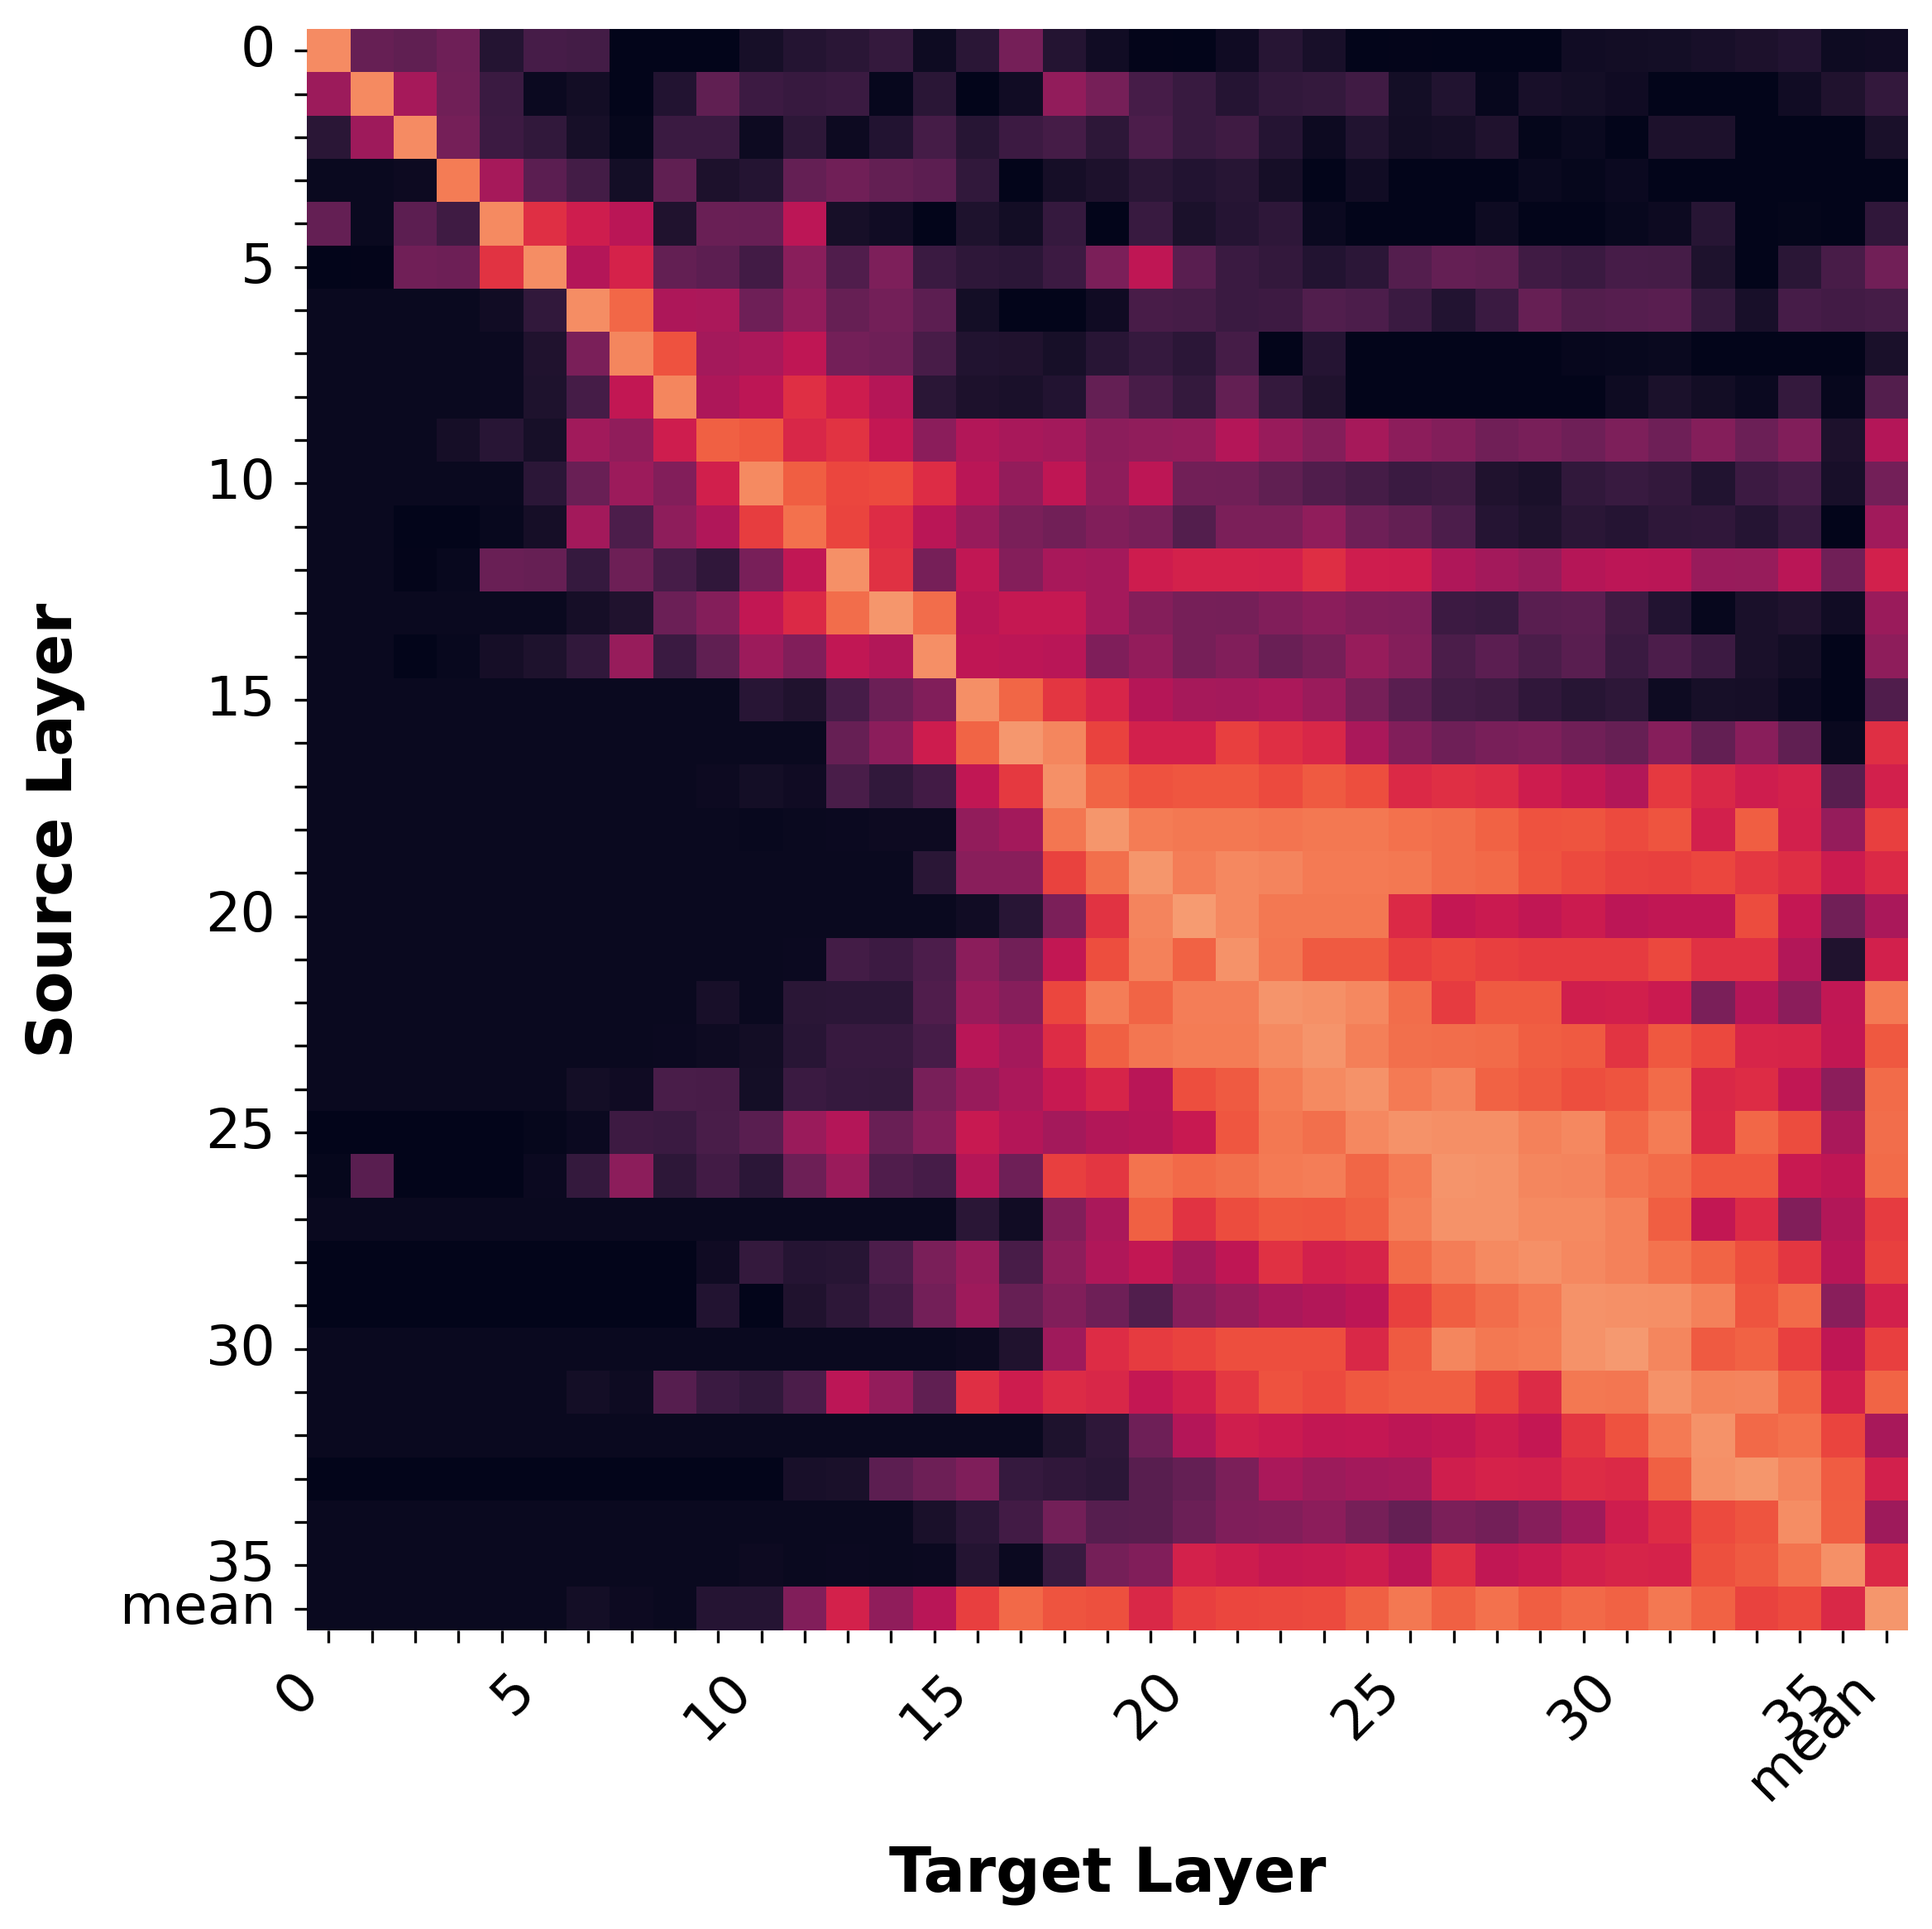

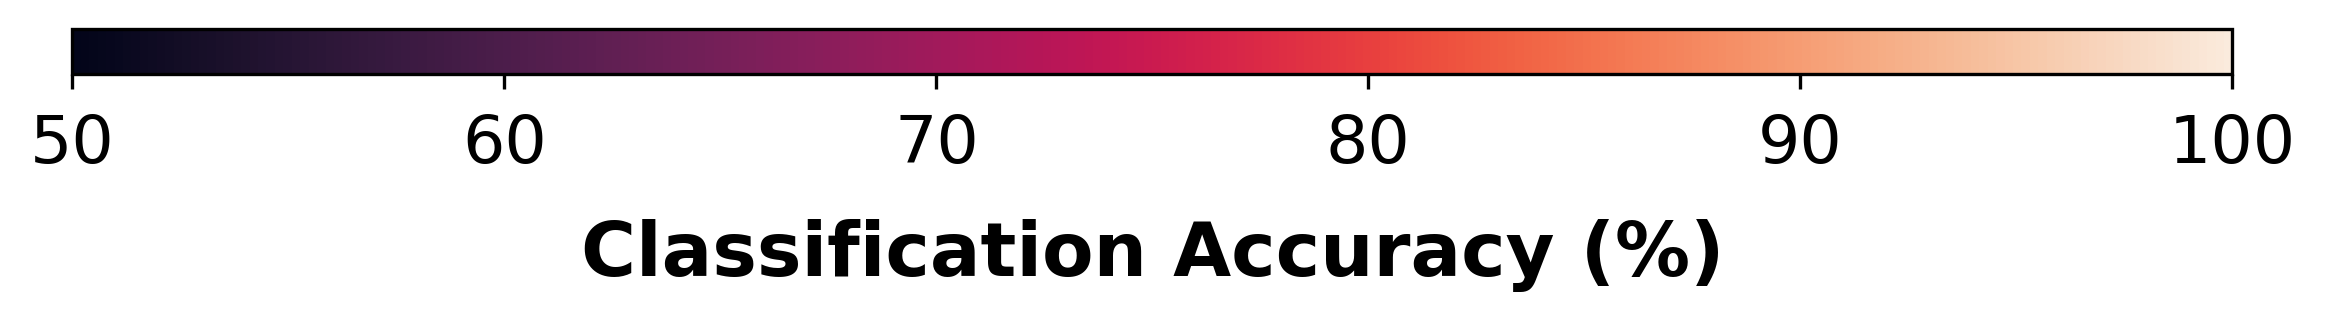

In [11]:
# parital run for untouchd layers


# transformer probe
fname_save_template = DATASETS_DIR / f"{publication}/{model_name}/layer_transfer_transformer_layer_accuracies_layer_accuracies.csv"
os.makedirs(os.path.dirname(fname_save_template), exist_ok=True)

for save_id in range(3):
    # Initialize or load existing results
    if os.path.exists(fname_save_template.format(save_id=save_id)):
        test_accuracies_transformer = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
        print(f"Loaded existing results for save_id {save_id}")
    else:
        test_accuracies_transformer = -1*np.ones((n_layers,n_layers))
        print(f"Starting new results for save_id {save_id}")

    for layer_train in tqdm.tqdm(range(n_layers)):
        # Skip if this layer's results are already computed
        if np.all(test_accuracies_transformer[layer_train,:] != -1):
            print(f"Skipping layer_train {layer_train} - already computed")
            continue
            
        # Initialize and train transformer probe
        transformer = TransformerProbe(input_size=train_activations.shape[-1])
        transformer.to("cuda")
        transformer.train_probe(
            train_data=train_activations[:,layer_train,:], 
            train_labels=train_labels, 
            num_epochs=500
        )
        
        # Test on all layers
        for layer_test in range(n_layers):
            # Skip if this specific result is already computed
            if test_accuracies_transformer[layer_train,layer_test] != -1:
                continue
                
            test_accuracy, conf_matrix = transformer.get_accuracy(
                test_data=test_activations[:,layer_test,:], 
                test_labels=test_labels
            )
            test_accuracies_transformer[layer_train,layer_test] = test_accuracy
            
            # Save after each layer_test computation
            np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies_transformer, delimiter=",")
    
# Load and average results
l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

# Plot results with transformer specifier
plot_layer_transfer_accuracy(test_accuracies_mean, model_name=model_name, specifier="transformer")

# subplots


In [9]:
from pathlib import Path
import os

# Import the init_paths module
from init_paths import (
    PROJECT_ROOT,
    DATASETS_DIR,
    ANALYSIS_DIR,
    EXPERIMENTS_DIR,
    IMAGES_DIR,
    GEN_DATA_DIR,
    LOGS_DIR,
    get_project_path
)

In [10]:
from analysis.supervised import *
from analysis.models import * 


In [12]:
import os
import pandas as pd 
import re

publication = ["public_1", "public_2"][1]

folder_path = DATASETS_DIR / f"prompt_activations/{publication}/"
files = os.listdir(folder_path)

models_list = list(models.keys())
model_name = models_list[0]


In [33]:
linear_files = [str(DATASETS_DIR / f"{publication}/{model_name}/layer_transfer_logistic_regression_layer_accuracies.csv") for model_name in models ]


In [34]:
mlp_files = [str(DATASETS_DIR / f"{publication}/{model_name}/layer_transfer_mlp_layer_accuracies_layer_accuracies.csv") for model_name in models ]



In [35]:
transformer_files = [str(DATASETS_DIR / f"{publication}/{model_name}/layer_transfer_transformer_layer_accuracies_layer_accuracies.csv") for model_name in models ]   


In [ ]:
def get_accuracies(files):  # Fixed typo in function name
    accuracies = []   
    print(f"Processing {len(files)} files")  # Debug print

    for file in files: 
        l_test_accuracies = []
        print(f"Processing file: {file}")  # Debug print
        
        try:
            test_accuracies_i = np.loadtxt(file, delimiter=",")
            l_test_accuracies.append(test_accuracies_i)
            
            if l_test_accuracies:  # Only compute mean if we have data
                test_accuracies_mean = np.mean(l_test_accuracies, axis=0)
                accuracies.append(test_accuracies_mean)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue

    print(f"Final number of accuracy arrays: {len(accuracies)}")  # Debug print
    return accuracies

# Load the data
linear_accuracies = get_accuracies(linear_files)
mlp_accuracies = get_accuracies(mlp_files)
transformer_accuracies = get_accuracies(transformer_files)

In [37]:
len(transformer_accuracies)

4

In [ ]:
def get_accuracies(files):
    accuracies = []
    print(f"Processing {len(files)} files")  # Debug print
    
    for file_template in files:
        print(f"Processing template: {file_template}")  # Debug print
        l_test_accuracies = []
        
        for save_id in range(3):
            filename = file_template.format(save_id=save_id)
            print(f"Loading file: {filename}")  # Debug print
            
            try:
                test_accuracies_i = np.loadtxt(filename, delimiter=",")
                l_test_accuracies.append(test_accuracies_i)
            except Exception as e:
                print(f"Error loading {filename}: {str(e)}")
                continue
                
        if l_test_accuracies:  # Only compute mean if we have data
            test_accuracies_mean = np.mean(l_test_accuracies, axis=0)
            print(f"Shape of mean accuracies: {test_accuracies_mean.shape}")  # Debug print
            accuracies.append(test_accuracies_mean)
        
    print(f"Final number of accuracy arrays: {len(accuracies)}")  # Debug print
    return accuracies

# Load the data
linear_accuracies = get_accuracies(linear_files)
mlp_accuracies = get_accuracies(mlp_files)
transformer_accuracies = get_accuracies(transformer_files)

# Debug prints
print("Number of linear accuracy arrays:", len(linear_accuracies))
print("Number of MLP accuracy arrays:", len(mlp_accuracies))
for i, (linear, mlp) in enumerate(zip(linear_accuracies, mlp_accuracies)):
    print(f"Model {i} shapes - Linear: {linear.shape}, MLP: {mlp.shape}")

In [50]:
def plot_model_comparisons(linear_accuracies_list, mlp_accuracies_list, transformer_accuracies_list, model_names):
    """
    Plot layer transfer accuracies for multiple models, comparing linear and MLP probes.
    """
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.labelpad': 15,
        'font.size': 20,
    })
    plt.rcParams.update({
    'text.usetex': False,
    'mathtext.default': 'regular'
    })

    num_models = len(model_names)
    # Adjust the width/height ratio in figsize
    fig, axes = plt.subplots(3, num_models, figsize=(28, 24), dpi=300)  # Made width smaller relative to height

    heatmap_params = {
        'annot': False,
        'vmin': 50,
        'vmax': 100,
        'cmap': 'rocket',
        'cbar': False
    }

    def get_matrix_metrics(acc):
        mask = ~np.eye(acc.shape[0], dtype=bool)
        mean_transfer = np.mean(acc[mask]) * 100
        max_transfer = np.max(acc[mask]) * 100
        max_idx = np.unravel_index(np.argmax(acc * mask), acc.shape)
        transfer_scores = np.mean(acc, axis=1)
        best_source_layer = np.argmax(transfer_scores)
        best_source_score = np.max(transfer_scores) * 100
        
        # Calculate percentage of values above thresholds
        total_values = acc[mask].size  # Count only off-diagonal elements
        above_50 = np.sum(acc[mask] * 100 > 50) / total_values * 100
        above_80 = np.sum(acc[mask] * 100 > 80) / total_values * 100
        
        return {
            'mean': f'★ {mean_transfer:.1f}%',
            'max': f'• {max_transfer:.1f}% (L{max_idx[0]}→L{max_idx[1]})',
            'best': f'■ L{best_source_layer} ({best_source_score:.1f}%)',
            'coverage': f'◆ >80%: {above_80:.1f}%'
        }

    plt.subplots_adjust(
        hspace=0.5,  # Increase vertical spacing between plots (was 0.2)
        wspace=0,  # Increase horizontal spacing between plots (was 0.1)
        top=0.95,    # Extend plots higher
        bottom=0.15, # Leave space for legend
        left=0.05,   # Adjust left margin
        right=0.95   # Adjust right margin
    )

    for idx, (linear_acc, mlp_acc, transformer_acc, model_name) in enumerate(zip(linear_accuracies_list, mlp_accuracies_list, transformer_accuracies_list, model_names)):
        num_layers = linear_acc.shape[0]
        xticklabels = [str(i) if i % 5 == 0 else "" for i in range(num_layers)]
        yticklabels = [str(i) if i % 5 == 0 else "" for i in range(num_layers)]

        # Linear probe plot (top row)
        ax_linear = axes[0, idx]
        sns.heatmap(linear_acc * 100, ax=ax_linear,
                    xticklabels=xticklabels,
                    yticklabels=yticklabels,
                    **heatmap_params)
        ax_linear.set_aspect('equal')
        metrics = get_matrix_metrics(linear_acc)
        
        # Update the values_text to include the new metric
        values_text = f"{metrics['coverage']}"
        ax_linear.text(0.5, -0.3, values_text,  # Adjusted y position to -0.3 to accommodate new line
                      ha='center', va='center', transform=ax_linear.transAxes,
                      fontsize=36, fontweight='normal')

        # Transformer probe plot (middle row)
        ax_transformer = axes[1, idx]
        sns.heatmap(transformer_acc * 100, ax=ax_transformer,
                    xticklabels=xticklabels,
                    yticklabels=yticklabels,
                    **heatmap_params)
        ax_transformer.set_aspect('equal')
        metrics = get_matrix_metrics(transformer_acc)
         # Update the values_text to include the new metric
        values_text = f"{metrics['coverage']}"
        ax_transformer.text(0.5, -0.3, values_text,  # Adjusted y position to -0.3 to accommodate new line
                      ha='center', va='center', transform=ax_transformer.transAxes,
                      fontsize=36, fontweight='normal')
        
        # MLP probe plot (bottom row)
        ax_mlp = axes[2, idx]
        sns.heatmap(mlp_acc * 100, ax=ax_mlp,
                    xticklabels=xticklabels,
                    yticklabels=yticklabels,
                    **heatmap_params)
        ax_mlp.set_aspect('equal')
        metrics = get_matrix_metrics(mlp_acc)
        # Update the values_text to include the new metric
        values_text = f"{metrics['coverage']}"
        ax_mlp.text(0.5, -0.3, values_text,  # Adjusted y position to -0.3 to accommodate new line
                      ha='center', va='center', transform=ax_mlp.transAxes,
                      fontsize=36, fontweight='normal')

        if idx == 0:
            ax_linear.set_ylabel('Source Layer', fontsize=36, fontweight='normal')
            ax_transformer.set_ylabel('Source Layer', fontsize=36, fontweight='normal')
            ax_mlp.set_ylabel('Source Layer', fontsize=36, fontweight='normal')

        ax_mlp.set_xlabel('Target Layer', fontsize=36, fontweight='normal', labelpad=120)
        
        for ax in [ax_linear, ax_transformer, ax_mlp]:
            ax.tick_params(axis='both', labelsize=18)
        
        if idx == num_models - 1:
            norm = plt.Normalize(vmin=50, vmax=100)
            cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
            plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='rocket'),
                         cax=cbar_ax, label='Classification Accuracy (%)')
            cbar_ax.tick_params(labelsize=18)
            cbar_ax.set_ylabel('Classification Accuracy (%)', fontsize=36)

    # Add row labels
    fig.text(-0.03, 0.85, 'Linear', fontsize=36, fontweight='bold', ha='right', va='center', rotation=90)
    fig.text(-0.03, 0.55, 'Transformer', fontsize=36, fontweight='bold', ha='right', va='center', rotation=90)
    fig.text(-0.03, 0.2, 'MLP', fontsize=36, fontweight='bold', ha='right', va='center', rotation=90)

    # Add model names (moved closer to final row)
    for i, model_name in enumerate(model_names):
        x_position = (i + 0.5) / num_models
        fig.text(x_position, 0, model_name, fontsize=36, fontweight='bold', ha='center', va='center')

    # Add metric descriptions as legend at bottom with symbols
    # legend_text = (
    #     "★ Average Cross-Layer Transfer - Mean accuracy when transferring between different layers\n"
    #     "• Best Single Transfer - Highest accuracy when transferring between specific non-diagonal layers (source→target)\n"
    #     "■ Most Transferable Layer - Layer that performs best as source when averaged across all target layers"
    # )
    legend_text = (
        "◆ Coverage (% of transfer pairs)"
    )
    # When adding the text to the figure, include the html parameter:
    fig.text(0.5, -0.05, legend_text, fontsize=36, fontweight='bold', ha='center', va='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=5),
            parse_math=True)

    # plt.tight_layout(rect=[0, 0.1, 0.95, 1])
    
    save_dir = IMAGES_DIR / f"{publication}/layer_transfer/"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/model_comparison_transfer_all_models.pdf", bbox_inches='tight', dpi=300)
    plt.show()

In [51]:
plot_model_comparisons(linear_accuracies, mlp_accuracies, transformer_accuracies, models)
